In [1]:
import numpy as np
import torch
import os

In [2]:
data_set = "/kaggle/input/indian-food-classification/Food Classification/"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 1. Transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


dataset = datasets.ImageFolder(
    root="/kaggle/input/indian-food-classification/Food Classification/",
    transform=data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

class_names = dataset.classes

In [5]:
print("Classes:", class_names)
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Classes: ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']
Train size: 5015, Test size: 1254


In [6]:
import torchvision.models as models
import torch.nn as nn

model_resnet = models.resnet18(pretrained= True)

for param in model_resnet.parameters():
    param.requires_grad = False

model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, 
                            out_features=len(dataset.classes))

model_resnet = model_resnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [7]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-4)
optimizer = torch.optim.Adam([
    {"params": model_resnet.fc.parameters(), "lr": 0.01},
    {"params": model_resnet.layer4.parameters(), "lr": 0.01}
], weight_decay=1e-4)

In [8]:
print(len(dataset.classes))

20


In [9]:
def train_step(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, total_correct = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(y_pred, dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / len(dataloader.dataset)
    return avg_loss, avg_acc

In [10]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            total_loss += loss.item()
            preds = torch.argmax(y_pred, dim=1)
            total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / len(dataloader.dataset)
    return avg_loss, avg_acc

In [11]:
epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train_step(model_resnet, train_dataloader, optimizer, loss_fn, device)
    test_loss, test_acc = test_step(model_resnet, test_dataloader, loss_fn, device)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/20] Train Loss: 1.8480, Train Acc: 0.5302 | Test Loss: 1.0134, Test Acc: 0.6930
Epoch [2/20] Train Loss: 1.0277, Train Acc: 0.7005 | Test Loss: 1.0221, Test Acc: 0.6938
Epoch [3/20] Train Loss: 0.9408, Train Acc: 0.7244 | Test Loss: 0.9690, Test Acc: 0.7249
Epoch [4/20] Train Loss: 0.9618, Train Acc: 0.7284 | Test Loss: 1.0853, Test Acc: 0.6946
Epoch [5/20] Train Loss: 0.9945, Train Acc: 0.7266 | Test Loss: 0.9335, Test Acc: 0.7632
Epoch [6/20] Train Loss: 0.9503, Train Acc: 0.7362 | Test Loss: 0.9537, Test Acc: 0.7344
Epoch [7/20] Train Loss: 0.9076, Train Acc: 0.7509 | Test Loss: 1.0350, Test Acc: 0.7305
Epoch [8/20] Train Loss: 0.9543, Train Acc: 0.7370 | Test Loss: 1.0275, Test Acc: 0.7153
Epoch [9/20] Train Loss: 0.9573, Train Acc: 0.7380 | Test Loss: 1.0151, Test Acc: 0.7376
Epoch [10/20] Train Loss: 0.9987, Train Acc: 0.7398 | Test Loss: 1.3039, Test Acc: 0.7026
Epoch [11/20] Train Loss: 0.9986, Train Acc: 0.7412 | Test Loss: 0.9905, Test Acc: 0.7424
Epoch [12/20] Train

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [28]:
def plot_confusion_matrix(model, dataloader, class_names, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix (force integers)
    cm = confusion_matrix(all_labels, all_preds).astype(int)

    # Plot (integer values)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Counts)")
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

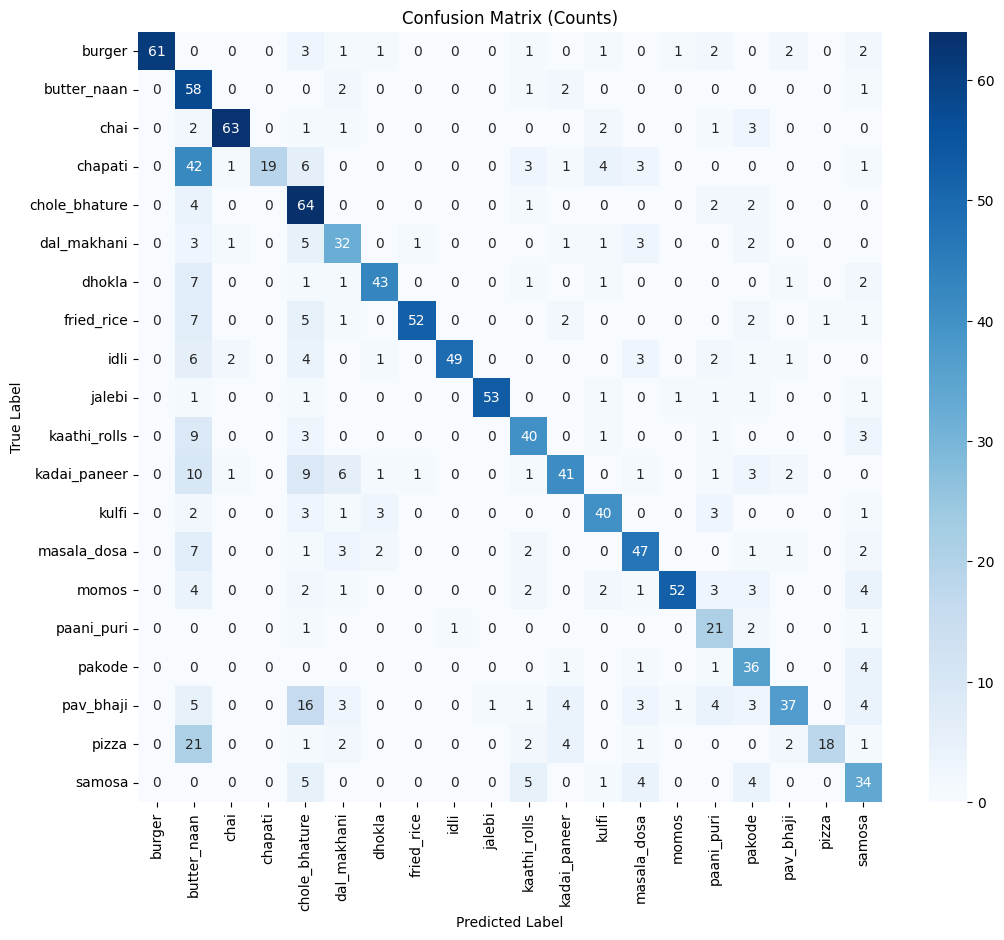


Classification Report:

               precision    recall  f1-score   support

       burger       1.00      0.81      0.90        75
  butter_naan       0.31      0.91      0.46        64
         chai       0.93      0.86      0.89        73
      chapati       1.00      0.24      0.38        80
chole_bhature       0.49      0.88      0.63        73
  dal_makhani       0.59      0.65      0.62        49
       dhokla       0.84      0.75      0.80        57
   fried_rice       0.96      0.73      0.83        71
         idli       0.98      0.71      0.82        69
       jalebi       0.98      0.88      0.93        60
 kaathi_rolls       0.67      0.70      0.68        57
 kadai_paneer       0.73      0.53      0.62        77
        kulfi       0.74      0.75      0.75        53
  masala_dosa       0.70      0.71      0.71        66
        momos       0.95      0.70      0.81        74
   paani_puri       0.50      0.81      0.62        26
       pakode       0.57      0.84     

In [29]:
plot_confusion_matrix(model_resnet, test_dataloader, class_names, device="cuda")